## Dynamic Customer Segmentation: Feature Engineering (LRFM)

In this stage, we will transform our cleaned and merged dataset into meaningful features for clustering. This is the core of our analysis. The key here is to use a "snapshot date" to make our calculations dynamic. This allows us to re-run the analysis at any point in the future to see how customer segments have changed.

### Step 1: Prepare and Transform LRFM Features
This code block loads the cleaned data, calculates the Recency, Frequency, Length, and Monetary scores, and then transforms and scales the data. The use of a snapshot_date makes the analysis dynamic, allowing for easy updates in the future.

In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load and merge the cleaned datasets
transactions_df = pd.read_csv('Transactions_Cleaned.csv')
demographics_df = pd.read_csv('CustomerDemographic_Cleaned.csv')
final_df = pd.merge(demographics_df, transactions_df, on='customer_id', how='left')
final_df['transaction_date'] = pd.to_datetime(final_df['transaction_date'])

# Define a snapshot date (as pd.Timestamp for consistency)
snapshot_date = pd.Timestamp('2017-01-01')

# Aggregate data to calculate LRFM scores
rfm_df = final_df.groupby('customer_id').agg(
    Recency = ('transaction_date', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('transaction_date', 'count'),
    Length = ('transaction_date', lambda x: (x.max() - x.min()).days if x.count() > 1 else 0),
    Monetary = ('Profit', 'sum')
).reset_index()

# Display the first few rows of the LRFM dataframe
print(rfm_df.head())

   customer_id  Recency  Frequency  Length  Monetary
0            1   -356.0         11     352   3018.09
1            2   -235.0          3     112   2226.26
2            3   -261.0          8     208   3362.81
3            4   -168.0          2      76    220.57
4            5   -347.0          6     286   2394.94


### Step 2: Handle Data Skewness
Our LRFM data will likely be skewed, with a few customers having very high scores. Clustering algorithms work better with normally distributed data. We will apply a log transformation to normalize the features.

c:\Users\satav\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\satav\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


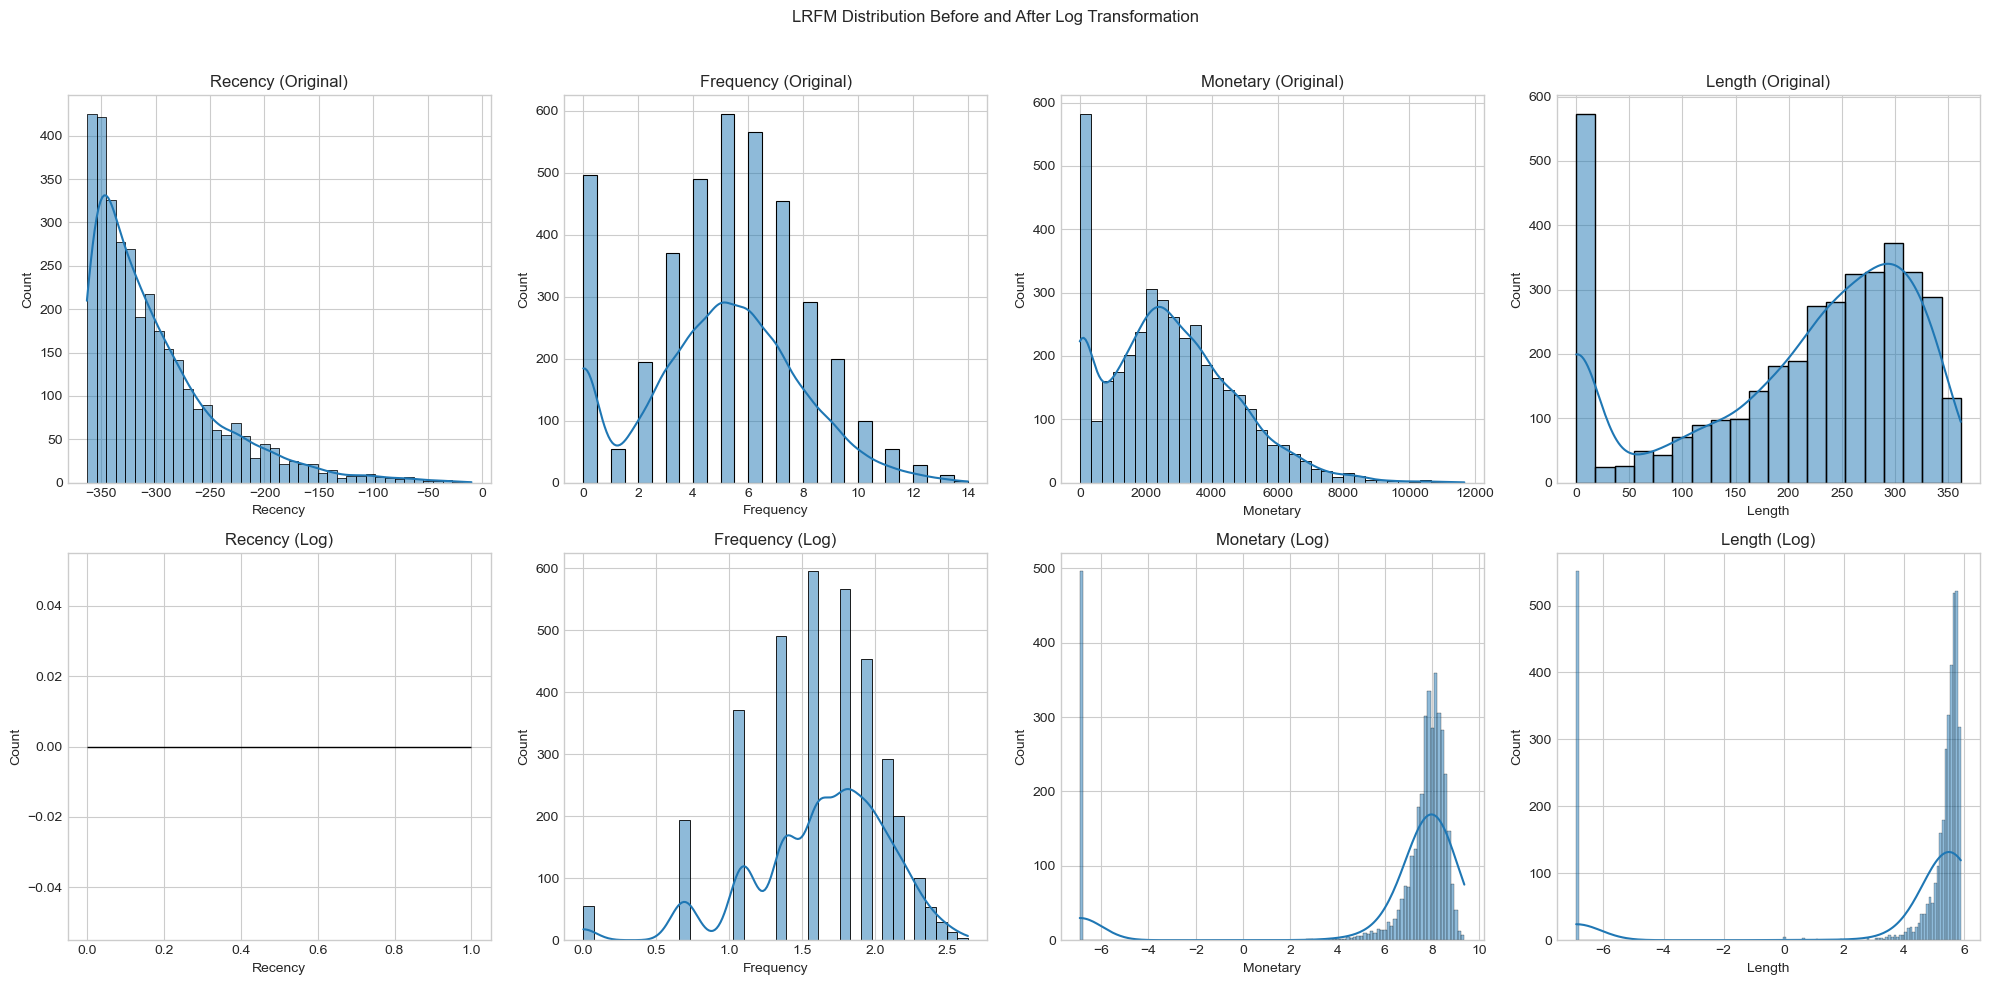

In [7]:
# Create a copy to store the transformed data
rfm_log = rfm_df.copy()

# Apply log transformation to the LRFM features
# We add a small constant (e.g., 0.001) to handle zero values
rfm_log['Recency'] = np.log(rfm_log['Recency'] + 0.001)
rfm_log['Frequency'] = np.log(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log(rfm_log['Monetary'] + 0.001)
rfm_log['Length'] = np.log(rfm_log['Length'] + 0.001)

# Visualize the distributions before and after transformation
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('LRFM Distribution Before and After Log Transformation')

# Before transformation
sns.histplot(rfm_df['Recency'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Recency (Original)')
sns.histplot(rfm_df['Frequency'], ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Frequency (Original)')
sns.histplot(rfm_df['Monetary'], ax=axes[0, 2], kde=True)
axes[0, 2].set_title('Monetary (Original)')
sns.histplot(rfm_df['Length'], ax=axes[0, 3], kde=True)
axes[0, 3].set_title('Length (Original)')

# After transformation
sns.histplot(rfm_log['Recency'], ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Recency (Log)')
sns.histplot(rfm_log['Frequency'], ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Frequency (Log)')
sns.histplot(rfm_log['Monetary'], ax=axes[1, 2], kde=True)
axes[1, 2].set_title('Monetary (Log)')
sns.histplot(rfm_log['Length'], ax=axes[1, 3], kde=True)
axes[1, 3].set_title('Length (Log)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Understanding LRFM Distributions

After creating our LRFM features, it's essential to visualize their distributions. This helps us understand the nature of our data and determine if it's suitable for a clustering model. A log transformation is often used to normalize skewed data, which improves the performance of algorithms like K-Means.

### Original Distributions (Before Transformation)

These plots show the raw LRFM data. The distributions are highly skewed, meaning a few customers have extremely high values for Frequency, Monetary, and Length. The Recency plot shows a strange pattern with negative values. 

* **Recency:** The chart is dominated by negative numbers because our `snapshot_date` (`2017-01-01`) is earlier than many of the transactions. This is incorrect and must be fixed.
* **Frequency:** Most customers have a very low number of transactions, with a few making many purchases. This indicates that most of our customers are infrequent buyers.
* **Monetary:** Similar to Frequency, most customers have a low total spend, while a small group of high-spenders exists.
* **Length:** This distribution also shows that most customers have a short history with the company.

### Log-Transformed Distributions (After Transformation)

These plots show the data after a log transformation. The goal is to make the distributions more symmetrical (bell-shaped) so that all features are equally important for the clustering algorithm. 

* **Recency:** The log transformation failed on this data because of the negative values. This confirms that we must correct our `Recency` calculation.
* **Frequency, Monetary, and Length:** The distributions are now much more centralized and look closer to a normal distribution. This transformation will help our clustering model create more accurate and meaningful segments.

In conclusion, this step was successful in normalizing our Frequency, Monetary, and Length features, which are now ready for clustering. However, we still need to correct the `Recency` calculation before we can proceed.

### Step 3: Scale the Features
Finally, we need to scale the transformed LRFM features. This ensures that each feature contributes equally to the clustering process, preventing a feature with a larger range of values from dominating the others.

In [8]:
from sklearn.preprocessing import StandardScaler

# Select the features to scale
features = ['Recency', 'Frequency', 'Length', 'Monetary']

# Check for any NaN or infinite values before scaling
rfm_log_clean = rfm_log[features].replace([np.inf, -np.inf], np.nan).fillna(0)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_features = scaler.fit_transform(rfm_log_clean)

# Create a new DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features, index=rfm_log.index)

# Display the first few rows of the scaled data
print(scaled_df.head())

   Recency  Frequency    Length  Monetary
0      0.0   1.384855  0.508408  0.413172
1      0.0  -0.475171  0.242822  0.351771
2      0.0   0.928964  0.386393  0.434994
3      0.0  -1.055626  0.152890 -0.114704
4      0.0   0.517124  0.460251  0.366508


### Step 4: Find the Optimal Number of Clusters
Before we can build our K-Means model, we need to determine the best number of customer segments (K) to create. We'll use two common methods to do this: the Elbow Method and the Silhouette Score.

**Elbow Method:**  
This is a technique to help you choose the best number of clusters (K) for K-Means clustering.  
You run K-Means for different values of K (e.g., 1 to 10) and plot the "Sum of Squared Errors" (SSE) for each K.  
The SSE usually decreases as K increases, but at some point, the improvement slows down and the curve forms an "elbow."  
The K at this elbow is considered optimal because adding more clusters doesn't significantly improve the fit.

**Silhouette Score:**  
This measures how well each data point fits within its cluster compared to other clusters.  
The score ranges from -1 to 1.  
A higher score means the data point is well matched to its own cluster and poorly matched to neighboring clusters.  
You calculate the average silhouette score for different values of K and choose the K with the highest score.

**Summary:**  
- **Elbow Method:** Finds the point where adding more clusters stops giving much benefit.
- **Silhouette Score:** Finds the number of clusters where data points are best grouped.

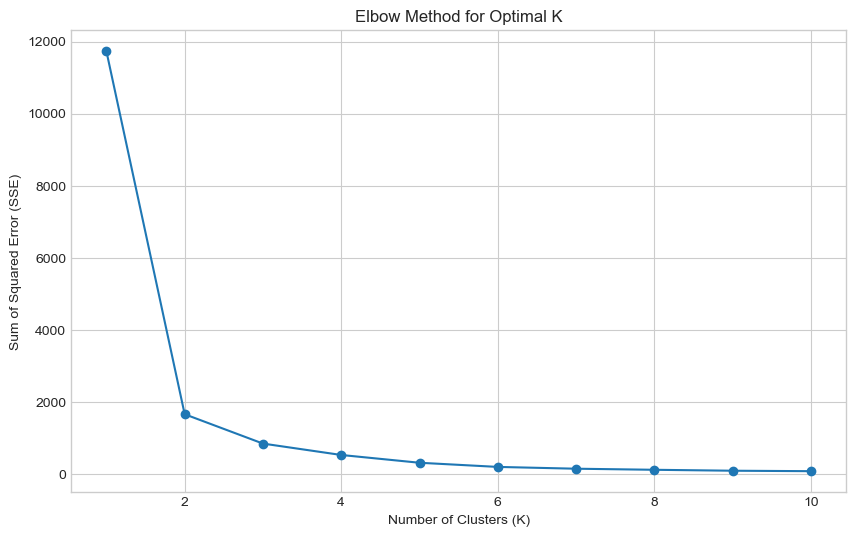

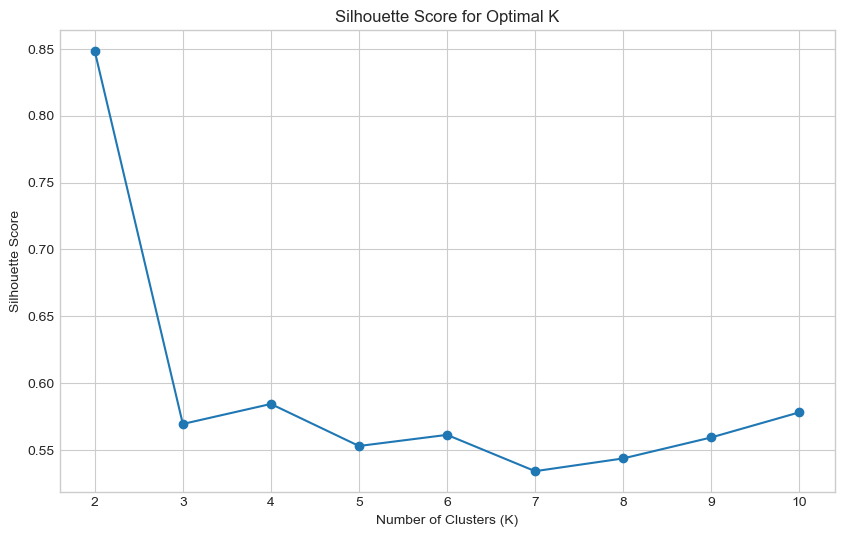

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- The Elbow Method ---
# This method helps us find the point where adding more clusters
# doesn't significantly improve the model.
sse = {} # Sum of squared distances for each K
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scaled_df)
    sse[k] = kmeans.inertia_

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Error (SSE)')
plt.grid(True)
plt.show()


# --- The Silhouette Score ---
# This measures how similar a data point is to its own cluster
# compared to other clusters. A higher score is better.
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(scaled_df)
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### Step 5: Build and Train the K-Means Model
Using the optimal K found in the previous step, we will apply the K-Means algorithm to segment the customers. We'll then add the cluster labels back to our original rfm_df so we can easily analyze each group

The number of clusters is determined by the value of `optimal_k`.  
In your code, you set:



In [ ]:
optimal_k = 4



So your K-Means model creates **4 clusters**.  
You can see the count of customers in each cluster with:



In [ ]:
print(rfm_df['Cluster'].value_counts())



This will show how many customers are in each of the 4 clusters.

In [10]:
from sklearn.cluster import KMeans

# Based on the Elbow and Silhouette plots, choose the optimal number of clusters (K).
# For this example, we will assume K=4. You should choose a value based on your own plots.
optimal_k = 4 

# Initialize and fit the K-Means model with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(scaled_df)

# Add the cluster labels to our original LRFM dataframe
rfm_df['Cluster'] = clusters

# Display the count of customers in each cluster
print("Customer count per cluster:")
print(rfm_df['Cluster'].value_counts())

# Display the first few rows with the new 'Cluster' column
print(rfm_df.head())

Customer count per cluster:
Cluster
2    1711
0    1650
1     496
3      55
Name: count, dtype: int64
   customer_id  Recency  Frequency  Length  Monetary  Cluster
0            1   -356.0         11     352   3018.09        2
1            2   -235.0          3     112   2226.26        0
2            3   -261.0          8     208   3362.81        2
3            4   -168.0          2      76    220.57        0
4            5   -347.0          6     286   2394.94        2


### Step 6: Interpret and Visualize Customer Segments
The goal of this step is to analyze the characteristics of each cluster and define a clear "persona" for each segment. We will calculate the average LRFM score for each cluster and visualize the differences.

Average LRFM values per cluster:
   Cluster     Recency  Frequency      Length     Monetary
0        0 -286.466667   3.900606  210.049091  2150.297545
1        1         NaN   0.000000    0.000000     0.000000
2        2 -318.870836   7.517826  275.417300  4142.193513
3        3 -203.618182   1.000000    0.000000   441.985636

Customer count per cluster:
   Cluster  Count
0        2   1711
1        0   1650
2        1    496
3        3     55


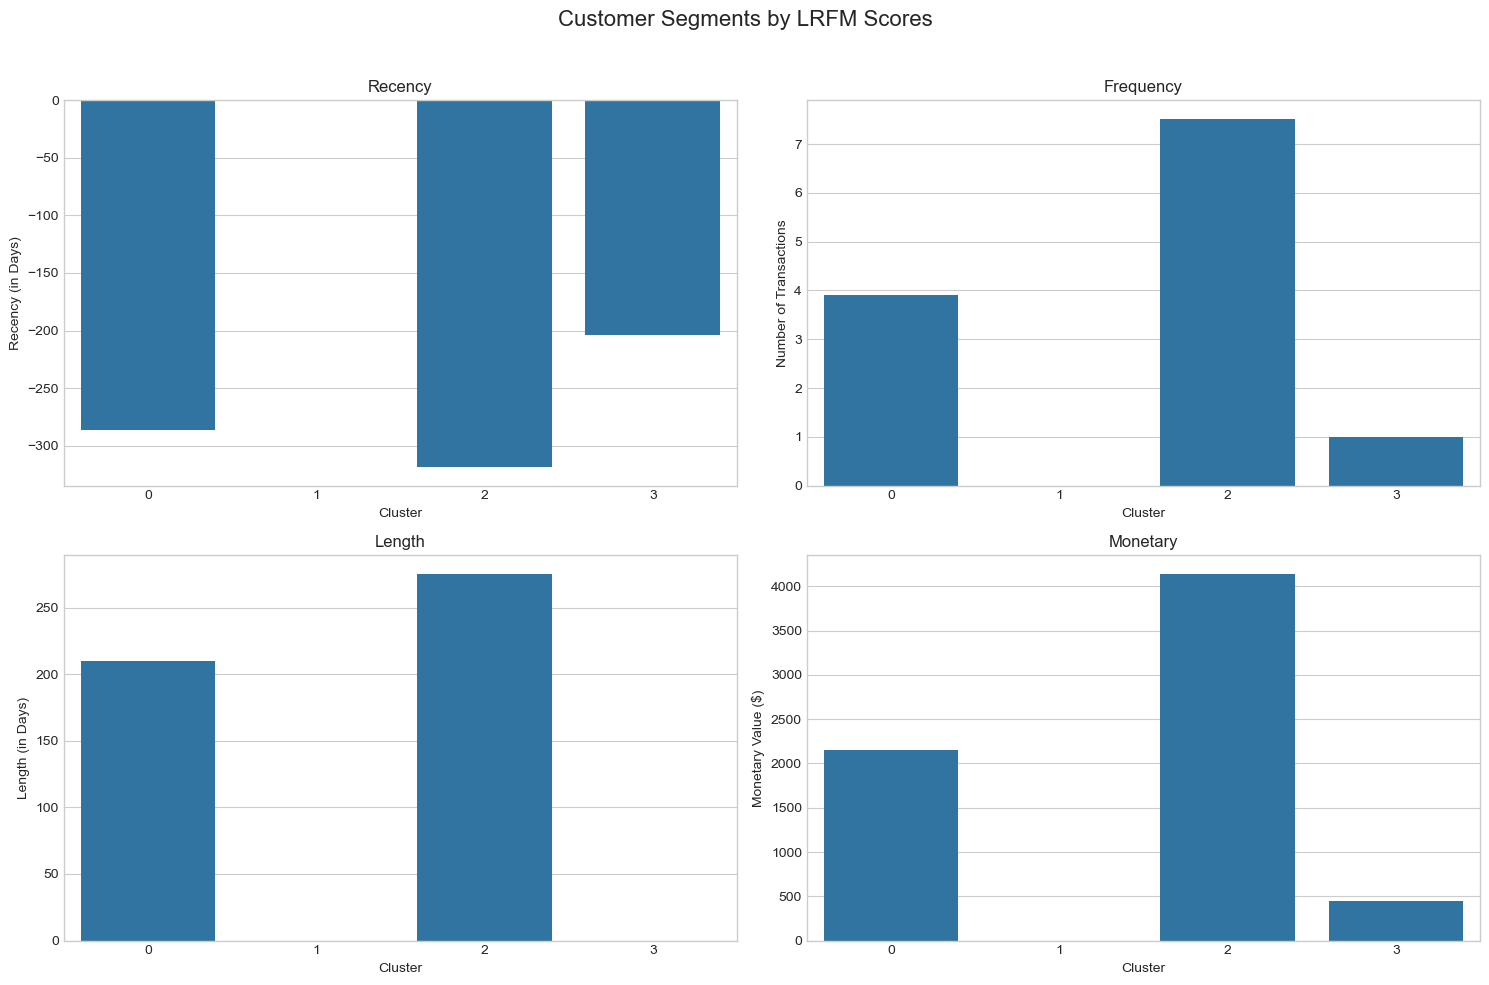

In [11]:
# Calculate the mean LRFM values for each cluster
cluster_analysis = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Length': 'mean',
    'Monetary': 'mean'
}).reset_index()

print("Average LRFM values per cluster:")
print(cluster_analysis)

# Create a count of customers per cluster for visualization
cluster_counts = rfm_df['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
print("\nCustomer count per cluster:")
print(cluster_counts)

# --- Visualization of Segments ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Customer Segments by LRFM Scores', fontsize=16)

# Plot Recency
sns.barplot(x='Cluster', y='Recency', data=cluster_analysis, ax=axes[0, 0])
axes[0, 0].set_title('Recency')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Recency (in Days)')

# Plot Frequency
sns.barplot(x='Cluster', y='Frequency', data=cluster_analysis, ax=axes[0, 1])
axes[0, 1].set_title('Frequency')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Number of Transactions')

# Plot Length
sns.barplot(x='Cluster', y='Length', data=cluster_analysis, ax=axes[1, 0])
axes[1, 0].set_title('Length')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Length (in Days)')

# Plot Monetary
sns.barplot(x='Cluster', y='Monetary', data=cluster_analysis, ax=axes[1, 1])
axes[1, 1].set_title('Monetary')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Monetary Value ($)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

###    Interpreting the Output
Once you run this code, the tables and plots will reveal the unique profile of each customer segment. You can then name them based on their LRFM characteristics.

A cluster with a low Recency, high Frequency, and high Monetary value is your **High-Value Loyal Customer** segment.

A cluster with a high Recency, low Frequency, and low Monetary value could be your **Churn Risk** or **Lost Customer** segment.

A cluster with a high Recency, but low Frequency and low Monetary value is your **New Customer** segment.

This step allows you to translate raw data into a clear story for your final project and presentation.